# Multimodal Base Image Classification and Regression using Keras

#### Source: https://www.pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/

## 0. Dependencies

In [0]:
import os
import argparse
import locale
import numpy as np
import pandas as pd
import glob
import cv2

In [0]:
from keras import datasets
import matplotlib.pyplot as plt

## 1. Dataset Collcection
### Source: https://github.com/emanhamed/Houses-dataset

In [9]:
!git clone https://github.com/emanhamed/Houses-dataset

Cloning into 'Houses-dataset'...
remote: Enumerating objects: 2166, done.
remote: Total 2166 (delta 0), reused 0 (delta 0), pack-reused 2166
Receiving objects: 100% (2166/2166), 176.26 MiB | 41.56 MiB/s, done.
Resolving deltas: 100% (20/20), done.


In [0]:
img = plt.imread('Houses-dataset/Houses Dataset/458_bathroom.jpg')

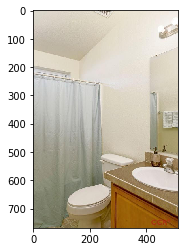

In [17]:
plt.imshow(img)

## 2. Data Preprocessing

In [0]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [18]:
len(os.listdir('Houses-dataset/Houses Dataset/'))

2141

In [0]:
def load_house_attributes(inputPath):
	# initialize the list of column names in the CSV file and then
	# load it using Pandas
	cols = ["bedrooms", "bathrooms", "area", "zipcode", "price"]
	df = pd.read_csv(inputPath, sep=" ", header=None, names=cols)
 
	# determine (1) the unique zip codes and (2) the number of data
	# points with each zip code
	zipcodes = df["zipcode"].value_counts().keys().tolist()
	counts = df["zipcode"].value_counts().tolist()
 
	# loop over each of the unique zip codes and their corresponding
	# count
	for (zipcode, count) in zip(zipcodes, counts):
		# the zip code counts for our housing dataset is *extremely*
		# unbalanced (some only having 1 or 2 houses per zip code)
		# so let's sanitize our data by removing any houses with less
		# than 25 houses per zip code
		if count < 25:
			idxs = df[df["zipcode"] == zipcode].index
			df.drop(idxs, inplace=True)
 
	# return the data frame
	return df

In [0]:
def process_house_attributes(df, train, test):
	# initialize the column names of the continuous data
	continuous = ["bedrooms", "bathrooms", "area"]
 
	# performin min-max scaling each continuous feature column to
	# the range [0, 1]
	cs = MinMaxScaler()
	trainContinuous = cs.fit_transform(train[continuous])
	testContinuous = cs.transform(test[continuous])
 
	# one-hot encode the zip code categorical data (by definition of
	# one-hot encoding, all output features are now in the range [0, 1])
	zipBinarizer = LabelBinarizer().fit(df["zipcode"])
	trainCategorical = zipBinarizer.transform(train["zipcode"])
	testCategorical = zipBinarizer.transform(test["zipcode"])
 
	# construct our training and testing data points by concatenating
	# the categorical features with the continuous features
	trainX = np.hstack([trainCategorical, trainContinuous])
	testX = np.hstack([testCategorical, testContinuous])
 
	# return the concatenated training and testing data
	return (trainX, testX)

In [0]:
def process_house_attributes(df, train, test):
	# initialize the column names of the continuous data
	continuous = ["bedrooms", "bathrooms", "area"]

	# performin min-max scaling each continuous feature column to
	# the range [0, 1]
	cs = MinMaxScaler()
	trainContinuous = cs.fit_transform(train[continuous])
	testContinuous = cs.transform(test[continuous])

	# one-hot encode the zip code categorical data (by definition of
	# one-hot encoding, all output features are now in the range [0, 1])
	zipBinarizer = LabelBinarizer().fit(df["zipcode"])
	trainCategorical = zipBinarizer.transform(train["zipcode"])
	testCategorical = zipBinarizer.transform(test["zipcode"])

	# construct our training and testing data points by concatenating
	# the categorical features with the continuous features
	trainX = np.hstack([trainCategorical, trainContinuous])
	testX = np.hstack([testCategorical, testContinuous])

	# return the concatenated training and testing data
	return (trainX, testX)

In [0]:
def load_house_images(df, inputPath):
	# initialize our images array (i.e., the house images themselves)
	images = []

	# loop over the indexes of the houses
	for i in df.index.values:
		# find the four images for the house and sort the file paths,
		# ensuring the four are always in the *same order*
		basePath = os.path.sep.join([inputPath, "{}_*".format(i + 1)])
		housePaths = sorted(list(glob.glob(basePath)))
    		# initialize our list of input images along with the output image
		# after *combining* the four input images
		inputImages = []
		outputImage = np.zeros((64, 64, 3), dtype="uint8")

		# loop over the input house paths
		for housePath in housePaths:
			# load the input image, resize it to be 32 32, and then
			# update the list of input images
			image = cv2.imread(housePath)
			image = cv2.resize(image, (32, 32))
			inputImages.append(image)

		# tile the four input images in the output image such the first
		# image goes in the top-right corner, the second image in the
		# top-left corner, the third image in the bottom-right corner,
		# and the final image in the bottom-left corner
		outputImage[0:32, 0:32] = inputImages[0]
		outputImage[0:32, 32:64] = inputImages[1]
		outputImage[32:64, 32:64] = inputImages[2]
		outputImage[32:64, 0:32] = inputImages[3]

		# add the tiled image to our set of images the network will be
		# trained on
		images.append(outputImage)

	# return our set of images
	return np.array(images)

In [0]:
# create datafram for tabular data
df = load_house_attributes('Houses-dataset/Houses Dataset/HousesInfo.txt')

In [31]:
df.head()

,bedrooms,bathrooms,area,zipcode,price
30,5,3.0,2520,93446,789000
32,3,2.0,1802,93446,365000
39,3,3.0,2146,93446,455000
80,4,2.5,2464,91901,599000
81,2,2.0,1845,91901,529800


In [0]:
# load image
images = load_house_images(df, 'Houses-dataset/Houses Dataset/')

In [0]:
# normalie the image dataset
images = images / 255.0

In [40]:
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
print("[INFO] processing data...")
split = train_test_split(df, images, test_size=0.25, random_state=42)
(trainAttrX, testAttrX, trainImagesX, testImagesX) = split


[INFO] processing data...


In [0]:
# find the largest house price in the training set and use it to
# scale our house prices to the range [0, 1] (will lead to better
# training and convergence)
maxPrice = np.max(trainAttrX["price"])
trainY = trainAttrX["price"] / maxPrice
testY = testAttrX["price"] / maxPrice



In [0]:
# process the house attributes data by performing min-max scaling
# on continuous features, one-hot encoding on categorical features,
# and then finally concatenating them together
(trainAttrX, testAttrX) = process_house_attributes(df,
	trainAttrX, testAttrX)

## 3. Model Architecture

In [0]:
from keras.models import *
from keras.layers import *
from keras.optimizers import *

In [0]:
def create_mlp(dim, regress=False):
	# define our MLP network
	model = Sequential()
	model.add(Dense(8, input_dim=dim, activation="relu"))
	model.add(Dense(4, activation="relu"))
 
	# check to see if the regression node should be added
	if regress:
		model.add(Dense(1, activation="linear"))
 
	# return our model
	return model

In [0]:
def create_cnn(width, height, depth, filters=(16, 32, 64), regress=False):
	# initialize the input shape and channel dimension, assuming
	# TensorFlow/channels-last ordering
	inputShape = (height, width, depth)
	chanDim = -1
 
	# define the model input
	inputs = Input(shape=inputShape)
 
	# loop over the number of filters
	for (i, f) in enumerate(filters):
		# if this is the first CONV layer then set the input
		# appropriately
		if i == 0:
			x = inputs
 
		# CONV => RELU => BN => POOL
		x = Conv2D(f, (3, 3), padding="same")(x)
		x = Activation("relu")(x)
		x = BatchNormalization(axis=chanDim)(x)
		x = MaxPooling2D(pool_size=(2, 2))(x)
    	# flatten the volume, then FC => RELU => BN => DROPOUT
	x = Flatten()(x)
	x = Dense(16)(x)
	x = Activation("relu")(x)
	x = BatchNormalization(axis=chanDim)(x)
	x = Dropout(0.5)(x)
 
	# apply another FC layer, this one to match the number of nodes
	# coming out of the MLP
	x = Dense(4)(x)
	x = Activation("relu")(x)
 
	# check to see if the regression node should be added
	if regress:
		x = Dense(1, activation="linear")(x)
 
	# construct the CNN
	model = Model(inputs, x)
 
	# return the CNN
	return model



In [48]:
# create the MLP and CNN models
mlp = create_mlp(trainAttrX.shape[1], regress=False)
cnn = create_cnn(64, 64, 3, regress=False)













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
# create the input to our final set of layers as the *output* of both
# the MLP and CNN
combinedInput = concatenate([mlp.output, cnn.output])

In [0]:
# our final FC layer head will have two dense layers, the final one
# being our regression head
x = Dense(4, activation="relu")(combinedInput)
x = Dense(1, activation="linear")(x)

In [0]:
# our final model will accept categorical/numerical data on the MLP
# input and images on the CNN input, outputting a single value (the
# predicted price of the house)
model = Model(inputs=[mlp.input, cnn.input], outputs=x)

#### Compile and Train the Model

In [0]:
opt = Adam(lr=1e-4, decay=1e-3 / 200)
model.compile(loss="mean_absolute_percentage_error", optimizer=opt)

In [62]:
# train the model
print("[INFO] training model...")
model.fit([trainAttrX, trainImagesX], trainY, validation_data=([testAttrX, testImagesX], testY),epochs=20, batch_size=8)

[INFO] training model...
Train on 271 samples, validate on 91 samples
Epoch 1/20
271/271 [==============================] - 2s 8ms/step - loss: 26.9408 - val_loss: 27.3332
Epoch 2/20
271/271 [==============================] - 1s 2ms/step - loss: 25.3833 - val_loss: 26.9400
Epoch 3/20
271/271 [==============================] - 1s 2ms/step - loss: 25.3203 - val_loss: 26.9687
Epoch 4/20
271/271 [==============================] - 1s 2ms/step - loss: 25.3603 - val_loss: 26.8992
Epoch 5/20
271/271 [==============================] - 1s 2ms/step - loss: 25.2710 - val_loss: 26.8603
Epoch 6/20
271/271 [==============================] - 1s 2ms/step - loss: 25.4392 - val_loss: 26.8496
Epoch 7/20
271/271 [==============================] - 1s 2ms/step - loss: 25.3006 - val_loss: 26.9344
Epoch 8/20
271/271 [==============================] - 1s 2ms/step - loss: 25.2600 - val_loss: 26.9094
Epoch 9/20
271/271 [==============================] - 1s 2ms/step - loss: 25.3233 - val_loss: 26.9191
Epoch 10/20


## 3. Model Evaluation 

In [63]:
# make predictions on the testing data
print("[INFO] predicting house prices...")
preds = model.predict([testAttrX, testImagesX])

[INFO] predicting house prices...


In [0]:
diff = preds.flatten() - testY
percentDiff = (diff / testY) * 100
absPercentDiff = np.abs(percentDiff)

In [0]:
mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)

In [66]:
# finally, show some statistics on our model
locale.setlocale(locale.LC_ALL, "en_US.UTF-8")
print("[INFO] avg. house price: {}, std house price: {}".format(
	locale.currency(df["price"].mean(), grouping=True),
	locale.currency(df["price"].std(), grouping=True)))
print("[INFO] mean: {:.2f}%, std: {:.2f}%".format(mean, std))

[INFO] avg. house price: $533,388.27, std house price: $493,403.08
[INFO] mean: 26.64%, std: 21.49%


## 4. Visuaize the Model Architecture

In [0]:
from keras.utils import plot_model

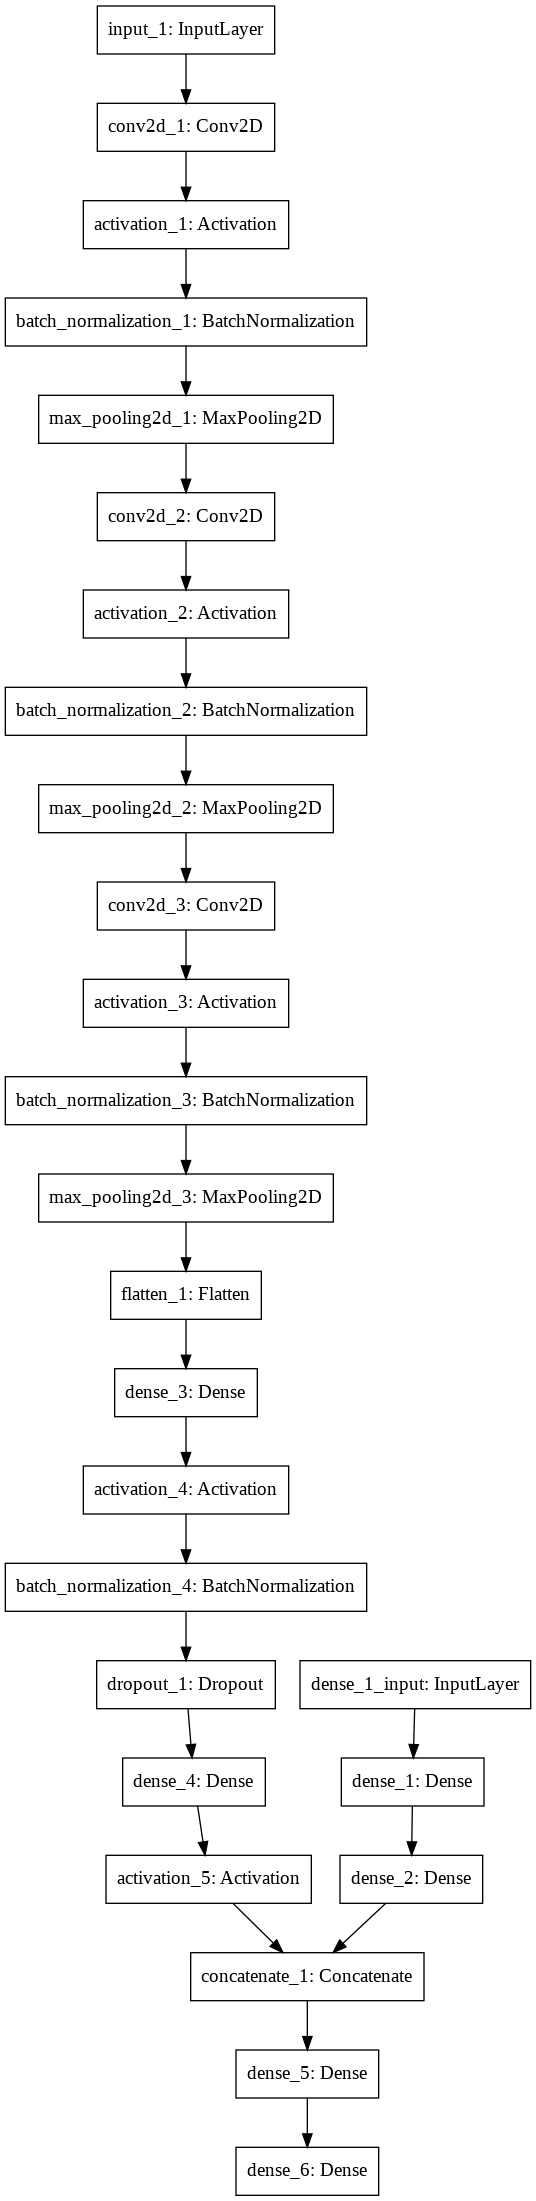

In [68]:
plot_model(model, to_file='model.png')